# 05-02 - Huffman Coding of symbol sequences

*May 22 2024*  

We implement a function that generates a Huffman tree and and use it for the lossless compression of symbol sequences. We compare the average per symbol length of compressed sequences with the entropy of the sequence and explore the asymptotic optimality of the Huffman code.

In [1]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

import pathpyG as pp
import scipy as sp

import queue
from collections import Counter

plt.style.use('default')
sns.set_style("whitegrid")

In the following, we implement a simple algorithm that constructs a Huffman coding tree for a given sequence of symbols. This algorithm first calculates the frequency of all symbols in the input sequence and adds them to a priority queue, which retrieves the symbol with lowest frequency first. For each symbol that we need to encode, we also add one leaf node to a tree data structure. We then repeatedly remove two nodes with lowest frequency from the priority queue. We add an (internal) node to the tree that points to those two nodes. The two links are labeled with 0 and 1, where 0 is assigned to the link to the node with lower frequency and 1 to the link to the node with higher frequency. We then add the newly constructed internal node to the priority queue, using the combined frequency of the two nodes to which it points as priority. 

Starting from the leaf nodes, this approach iteratively constructs a coding tree. The algorithm terminates when there is only one node left in the queue, which is the root of the tree.

Our implementation below uses `pathpy` to generate the coding tree, which has the advantage that we can nicely visualize the output:

In [2]:
def huffman_tree(sequence):

    counts = Counter(sequence).most_common()
    seq_length = len(sequence)

    # symbols with lowest frequency have highest priority
    q = queue.PriorityQueue()
    
    labels = {}
    node_type = {}
    for (symbol, count) in counts:
        # create leaf nodes and add to queue
        labels[symbol]='{0} / {1:.3f}'.format(symbol, count/seq_length)
        q.put((count, symbol))
        node_type[symbol] = 'leaf'        
    # Create huffman tree
    i = 0
    
    edges = []
    edge_symbols = []
    
    while q.qsize()>1:

        # retrieve two symbols with minimal frequency
        left = q.get()
        right = q.get()

        total_frequency = left[0] + right[0]

        # create internal node v with total frequency as label
        v = 'n_' + str(i)
        label = '{:.2f}'.format(total_frequency/seq_length)
        labels[v] = label
        node_type[v] = 'internal'
        edges.append((v,left[1]))
        edge_symbols.append('0')
        edges.append((v,right[1]))
        edge_symbols.append('1')

        q.put((left[0] + right[0], v))
        i += 1

    # the remaining entry corresponds to the root node
    root = q.get()
    huffman_tree=pp.Graph.from_edge_list(edges)
    huffman_tree.data.node_labels = [labels[v] for v in huffman_tree.nodes]
    huffman_tree.data.node_type = [node_type[v] for v in huffman_tree.nodes]
    huffman_tree.data.edge_symbols = edge_symbols
    return huffman_tree, root[1]

Let us try this in an example sequence that consists of four letters `a`, `b`, `c` and `d`.

In [3]:
text = 'aaabaabaaaaabaaaccaaacaaadaad'
tree, root = huffman_tree(text)
print(tree)
tree.data.node_colors = ['orange' if x == 'leaf' else 'grey' for x in tree.data.node_type]

pp.plot(tree, node_label = tree.data.node_labels, edge_color= ['green' if x == '1' else 'red' for x in tree.data.edge_symbols], node_color = tree.data.node_colors)

Directed graph with 7 nodes and 6 edges

Node attributes
	node_labels		<class 'list'>
	node_type		<class 'list'>

Edge attributes
	edge_symbols		<class 'list'>

Graph attributes
	num_nodes		<class 'int'>



Above, we have colored internal (i.e. non-leaf nodes) in gray, while leaf nodes that correspond to the encoded symbols are colored in orange. We also include the relative (aggregate) frequencies of the leaf nodes and the corresponding subtrees. In the example above, we obtain an imbalanced tree since the symbol `a` appears much more frequently than the other symbols. Due to this imbalance in the depth of the tree, we use a shorter one bit codeword for the symbol `a`, while all other symbols are encoded with two or three bits.

In order to actually use the coding tree to compress a sequence, we can create a mapping dictionary that gives the codeword for each symbol in the input sequence. Such a mapping can be easily constructed by recursively traversing the coding tree, building up the codewords as we descend from the root and adding them to the mapping whenever we encounter a leaf node:

In [4]:
def generate_mapping(tree, node, prefix='', lookup_table={}):
    """Recursively turns Huffman tree into a lookup dictionary"""
    if tree.out_degrees[node] == 0:
        lookup_table[node] = prefix
    else:
        for x in tree.successors(node):
            generate_mapping(tree, x, prefix=prefix + tree['edge_symbols'][list(tree.edges).index((node, x))], lookup_table=lookup_table)

    return lookup_table

Let's try this in our example:

In [5]:
lookup_table = generate_mapping(tree, root)
print(lookup_table)

{'c': '00', 'd': '010', 'b': '011', 'a': '1'}


We can now compress the sequence and compare the length. Note that, to fairly compare the sequences, we must consider a binary encoding of the input sequence. Since we have four different symbols, a naive encoding would require two bits per symbol: 

In [6]:
compressed = ''.join([lookup_table[x] for x in text])
print(compressed)
print('Original:   {0} bits'.format(len(text)*2))
print('Compressed: {0} bits'.format(len(compressed)))

111011110111111101111100001110011101011010
Original:   58 bits
Compressed: 42 bits


To decompress the sequence we can parse the encoding bit by bit, while traversing the tree. Whenever we encounter a leaf node, we emit the corresponding symbol to the decoded sequence and continue the decoding of the next bit at the root node of the tree. This also explains why the Huffman code is a prefix-free code: The encoding of one symbol is implicitly terminated whenever we read a leaf in the coding tree.

In [7]:
def decompress(tree, root, compressed_sequence):

    original_sequence = []
    ptr = root

    # traverse tree to recover original symbol
    i = 0
    while i<len(compressed_sequence):
        if tree.out_degrees[ptr] > 0:
            # move along left/right edge depending on symbol
            edges = {tree['edge_symbols'][list(tree.edges).index((ptr, x))]:(ptr, x) for x in tree.successors(ptr)}
            ptr = edges[compressed_sequence[i]][1]
            i += 1
        else: # leaf node: emit node name and restart in root for next symbol
            original_sequence.append(ptr)
            ptr = root
    original_sequence.append(ptr)
    return ''.join(original_sequence)

We can now recover our original sequence:

In [8]:
print(text)
print(decompress(tree, root, compressed))

aaabaabaaaaabaaaccaaacaaadaad
aaabaabaaaaabaaaccaaacaaadaad


We can explore this in another example, where we have variable length sequences with unequal symbol probabilities. To simplify the construction of such a sequence, we use the following function:

In [9]:
def generate_sequence(sybols, probs, n):
    return ''.join([x for x in np.random.choice(symbols, size=n, p=probs)])

We now use this to generate a sequence with 100 symbols, encode the sequence and calculate the average bits required per symbol in the sequence:

In [10]:
symbols = ['a', 'b', 'c', 'd']
probs = [0.125, 0.125, 0.5, 0.25]
text = generate_sequence(symbols, probs, 100)
print(text)

tree, root = huffman_tree(text)
lookup_table = generate_mapping(tree, root)
compressed = ''.join([lookup_table[x] for x in text])
print(compressed)

print('Original:   {0} bits/symbol'.format(np.log2(len(set(text)))))
print('Compressed: {0} bits/symbol'.format(len(compressed)/100))

cacccdcdccdbcbcbdaccccccaabacdbddacbdccccdacacaccdcdcccccbccccccdcdccbccdbccdcdcacccacbacdcccccbadcd
10111110010011000101010101000011111111011011010011100010000001110100011110001110111011110010011111010111111001001101011000101100100101111101110100111001111101001100100
Original:   2.0 bits/symbol
Compressed: 1.67 bits/symbol


In the lecture, we have discussed that a lower bound for the minimal expected number of bits per symbol is given by the entropy of the probability mass function of the symbols. Moreover, the Huffman code is asymptotically optimal for sequences of length $n$, i.e. for $n \rightarrow \infty$ the expected per-symbol code length required by the Huffman coding scheme converges to this lower bound. 

Let us explore this in practice. We will use `scipy.stats.entropy` to calculate the entropy of the symbol frequencies, i.e. the lower bound for the expected per-symbol length of a lossless coding scheme, for our example:

In [11]:
sp.stats.entropy(probs, base=2)

1.75

We can now generate random sequences of increasing length $n$ based on this probability distribution, generate a Huffman code, encode the sequence and calculate the bits per symbol. We can further use Shannon's source coding theorem to calculate the lower bound for the per-symbol code length of a lossless coding. We find that the per-symbol length of the Huffman encoded sequence converges to the limit given by the Shannon entropy.

In [12]:
samples = 1000
avg_code_lengths = []
for n in range(10, 1000, 50):
    L = 0
    for s in range(samples):    
        text = generate_sequence(symbols, probs, n)
        tree, root = huffman_tree(text)
        lookup_table = generate_mapping(tree, root)
        compressed = ''.join([lookup_table[x] for x in text])
        L += len(compressed)/n
    avg_code_lengths.append(L/samples)

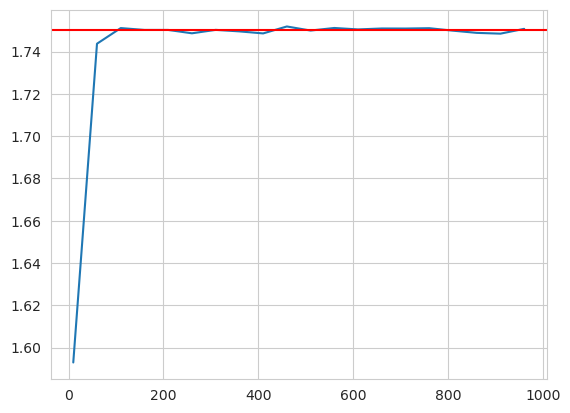

In [13]:
plt.plot(range(10,1000, 50), avg_code_lengths)
plt.axhline(y=sp.stats.entropy(probs, base=2), color='red')

We indeed find that the average per-symbol code length in the compressed sequences converges to the Shannon entropy of the underlying probability mass function that describes the symbol frequencies. Since this is the theoretical lower bound of a lossless encoding, we can say that the Huffman code provides an optimal compression (under the assumption that we are actually interested in a lossless compression and that the symbols are i.i.d.).